In [ ]:
!pip install similaritymeasures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for similaritymeasures: filename=similaritymeasures-0.7.0-py3-none-any.whl size=15452 sha256=06f7cbd269e1ce004a98136d65f4ef9b2ebfdd1884021c89300c621e33aa9483
  Stored in directory: /root/.cache/pip/wheels/ec/5a/ff/cb7b340273d1c9024c084633cc8f19b7684584182b05ae93d5
Successfully built similaritymeasures


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
cd /content/drive/MyDrive/NewDesktopDSP

/content/drive/.shortcut-targets-by-id/1EgVS0IJfLItcsy3sZfzn4-1oxy0EVmyE/NewDesktopDSP


In [1]:
from analysis import Loader
from analysis import MovementAnalyzer, RotationAnalyzer
import pandas as pd
import numpy as np
from analysis import ShortcutMap
import random

In [2]:
pd.set_option('display.max_column', 500)

loader = Loader(data_dir="alldata", extra_dir="extra", image_dir="images")
loader.load(learning=True)

shortcut_map = ShortcutMap("extra/new_walls.csv", "extra/objects.csv", "extra/new_shortcuts.csv")
learning_map = ShortcutMap("extra/learning_walls.csv", "extra/objects.csv", "extra/learning_shortcuts.csv")

ShortcutMap: Loaded 12 objects
ShortcutMap: Loaded 12 objects


In [3]:
# Currently the movement analyzer can only handle normal (not alternative) trials, will add that later this week
movement_analyzer = MovementAnalyzer(loader, shortcut_map=shortcut_map, learning_map=learning_map)

# rotation analyzer gives the absolute angular error for each trial (both normal and alternative)
rotation_analyzer = RotationAnalyzer(loader)

efficiencies = movement_analyzer.calculate_efficiency_for_all_subjects()
#print(efficiencies)

failures = movement_analyzer.calculate_failure_for_all_subjects()
#print(failures)

errors = rotation_analyzer.calculate_estimation_error_for_all_subjects(3,23)
#print(errors)

In [4]:
frechet_distances = movement_analyzer.calculate_frechet_for_all_subjects()

In [5]:
frechet_table = pd.DataFrame.from_dict(frechet_distances).transpose()

# assume your data is stored in a pandas DataFrame called df
# with participant names as index and trial numbers as columns

# define a function to check if the shortcut value is minimum among ('shortcut', 'shortcut_reversed', 'lean', 'topo')

def is_shortest(col):
    shortcuts = [col['shortcut'], col['shortcut_reversed'], col['learn'], col['topo']]
    check = col['shortcut'] == min(shortcuts) and col['failure'] == 0
    return check

def process_each_subject(row):
    return row.apply(is_shortest).sum()

# use pandas' apply method to apply the is_shortest function to each row of the DataFrame
# then use pandas' sum method to count the number of rows where failure == 0 and shortcut is the minimum value
solution_index = frechet_table.apply(lambda row: row.apply(is_shortest).sum(), axis=1)/20

# change the row indexing to a column
solution_index = solution_index.reset_index()
# change the only column name to 'solution_index'
solution_index = solution_index.rename(columns={0:'solution_index'})
solution_index

,index,solution_index
0,AB04KO,0.5
1,JE02DE,0.4


In [6]:

eff = pd.DataFrame.from_dict(efficiencies).transpose()
eff = eff.reset_index().rename(columns = {'index':'subID'})
sub_failure = pd.DataFrame(failures,index=[0]).transpose().reset_index().rename({'index':'subID',0:'num_failures'},axis=1)
point_err = pd.DataFrame.from_dict(errors).transpose()
point_err = point_err.reset_index().rename(columns = {'index':'subID'})
eff['eff_avg'] = eff.iloc[:,1:].mean(axis=1)
point_err['point_avg'] = point_err.iloc[:,1:].mean(axis=1)
dsp_sub = eff[['subID','eff_avg']].merge(point_err[['subID','point_avg']],on='subID').merge(sub_failure,on='subID')
dsp_sub

,subID,eff_avg,point_avg,num_failures
0,AB04KO,1.809456,66.202485,4
1,JE02DE,1.720813,49.897520,6


In [7]:
# merge solution_index with dsp_sub using column 'subID' in dsp_sub and 'index' in frechet_table but do not keep the index column in frechet_table
dsp_sub = dsp_sub.merge(solution_index, left_on='subID', right_on='index').drop('index', axis=1)
dsp_sub

,subID,eff_avg,point_avg,num_failures,solution_index
0,AB04KO,1.809456,66.202485,4,0.5
1,JE02DE,1.720813,49.897520,6,0.4


In [8]:
dsp_sub.to_csv("dsp_sub.csv",index=False)

In [10]:
movement_analyzer.export_distance_summary()

In [11]:
movement_analyzer.export_processed_data_for_all_subjects()

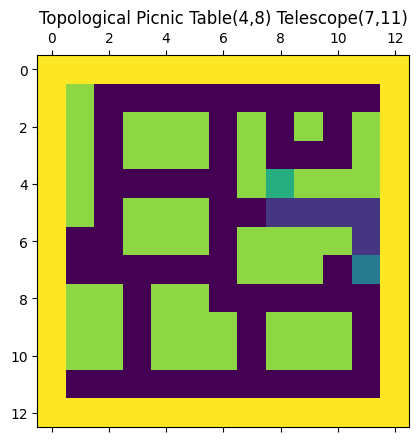

In [7]:
movement_analyzer.plot_all_topological_paths(folder="topo_plot", save_only=True)